In [75]:
import os
import glob
import cv2
import imageio
import pickle
import numpy as np
import pandas as pd
import nibabel as nib
from PIL import Image
from tabulate import tabulate
import matplotlib.pyplot as plt
from ipywidgets import *
from matplotlib.pyplot import figure
from tqdm.notebook import tqdm
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *
try:
    import pixellib
    from pixellib.instance import instance_segmentation
except ImportError:
    !pip install pixellib
    import pixellib
    from pixellib.instance import instance_segmentation

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk(r"/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1"):
    for filename in filenames:
        file_list.append((dirname, filename))

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename'])
df_files.sort_values(by=['filename'], ascending=True)


,dirname,filename
1,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-0.nii
0,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-1.nii
2,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-10.nii
3,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-11.nii
4,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-12.nii
5,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-13.nii
6,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-14.nii
7,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-15.nii
8,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-16.nii
9,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-17.nii


In [79]:
# # Map CT scan and label

df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"

    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = r"/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True)

df_files

,dirname,filename,mask_dirname,mask_filename
0,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,volume-0.nii,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-0.nii
1,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,volume-1.nii,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-1.nii
2,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,volume-10.nii,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-10.nii
3,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,volume-11.nii,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-11.nii
4,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,volume-12.nii,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-12.nii
5,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,volume-13.nii,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-13.nii
6,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,volume-14.nii,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-14.nii
7,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,volume-15.nii,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-15.nii
8,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,volume-21.nii,/content/drive/MyDrive/Liver Tumor Seg-Classify/Training_Batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1,segmentation-21.nii


In [ ]:
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [ ]:
sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Define the output folder path
output_folder = '/content/drive/MyDrive/Liver Tumor Seg-Classify/NewFolder'

# Check if the output folder already exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created new folder: {output_folder}")
else:
    print(f"Folder already exists: {output_folder}")

# Define the subfolder names for CT and mask images
ct_folder = 'ct'
mask_folder = 'mask'

# Define the paths for the CT and mask subfolders
ct_folder_path = os.path.join(output_folder, ct_folder)
mask_folder_path = os.path.join(output_folder, mask_folder)

# Check if CT and mask folders already exist within the output folder
if os.path.exists(ct_folder_path) and os.path.exists(mask_folder_path):
    print("CT and mask images already exist. Skipping saving.")
else:
    # Create the CT and mask subfolders
    os.makedirs(ct_folder_path, exist_ok=True)
    os.makedirs(mask_folder_path, exist_ok=True)

    # Define the paths of the sample and sample_mask files
    sample_path = df_files.loc[sample, 'dirname'] + '/' + df_files.loc[sample, 'filename']
    sample_mask_path = df_files.loc[sample, 'mask_dirname'] + '/' + df_files.loc[sample, 'mask_filename']

    # Read the sample and sample_mask files
    sample_ct = read_nii(sample_path)
    sample_mask = read_nii(sample_mask_path)

    # Convert data type to unsigned 8-bit integers
    sample_ct = (sample_ct * 255).astype(np.uint8)
    sample_mask = (sample_mask * 255).astype(np.uint8)

    # Save slices of the sample CT as PNG images
    for i in range(sample_ct.shape[-1]):
        # Get the CT and mask slices
        ct_slice = sample_ct[:, :, i]
        mask_slice = sample_mask[:, :, i]

        # Save the CT slice if it doesn't already exist
        ct_slice_path = os.path.join(ct_folder_path, f'slice_{i}.png')
        if not os.path.exists(ct_slice_path):
            plt.imsave(ct_slice_path, ct_slice, cmap='gray')

        # Save the mask slice if it doesn't already exist
        mask_slice_path = os.path.join(mask_folder_path, f'slice_{i}.png')
        if not os.path.exists(mask_slice_path):
            plt.imsave(mask_slice_path, mask_slice, cmap='gray')

    print("CT and mask slices saved as PNG images.")


Folder already exists: /content/drive/MyDrive/NewFolder
CT and mask images already exist. Skipping saving.


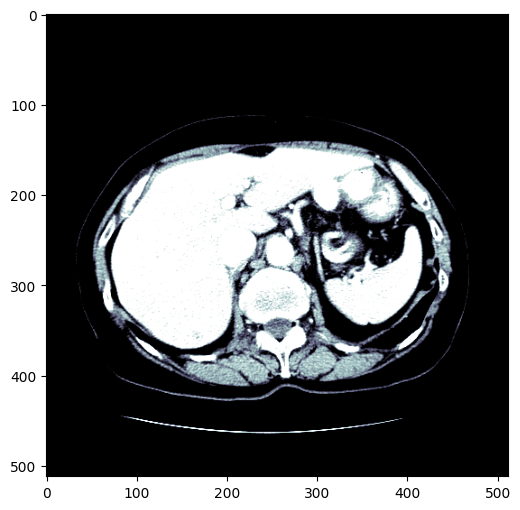

In [ ]:
dicom_windows = types.SimpleNamespace(brain=(80,40),subdural=(254,100),stroke=(8,32),brain_bone=(2800,600),brain_soft=(375,40),lungs=(1500,-600),mediastinum=(350,50),abdomen_soft=(400,50),liver=(150,30),spine_soft=(250,50),spine_bone=(1800,400),custom = (200,60))
@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)
figure(figsize=(8, 6), dpi=100)
plt.imshow(tensor(sample_ct[..., 60].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [ ]:
imf = sample_ct[..., sample]
imf.shape

(512, 512)

In [ ]:
#pre processing using bi-later filtering with MBO
import cv2
import numpy as np

def initialize_population(search_space, population_size):
    population = []
    for _ in range(population_size):
        solution = [np.random.uniform(low, high) for low, high in search_space]
        population.append(solution)
    return population

def evaluate_fitness(solution, image):
    # Apply bilateral filtering using the solution as parameters
    filtered_image = cv2.bilateralFilter(image, d=-1, sigmaColor=solution[0], sigmaSpace=solution[1])
    # Calculate fitness as the negative mean squared error between the filtered image and the original image
    fitness = -np.mean(np.square(image - filtered_image))
    return fitness

def update_flight_direction(population, fitness_values, best_solution):
    flight_directions = []
    for i, solution in enumerate(population):
        r1 = np.random.random()
        r2 = np.random.random()
        butterfly = [solution[j] + r1 * (best_solution[j] - solution[j]) + r2 * (population[i][j] - solution[j])
                     for j in range(len(solution))]
        flight_directions.append(butterfly)
    return flight_directions

def update_position(population, flight_directions, search_space):
    new_population = []
    for i, solution in enumerate(population):
        new_solution = [solution[j] + flight_directions[i][j] for j in range(len(solution))]
        new_solution = [np.clip(new_solution[j], search_space[j][0], search_space[j][1]) for j in range(len(solution))]
        new_population.append(new_solution)
    return new_population

def bilateral_filtering_mbo(image, population_size, max_iterations):
    # Define the search space for bilateral filtering parameters (sigmaColor, sigmaSpace)
    search_space = [(1, 200), (1, 200)]

    # Initialize population of solutions
    population = initialize_population(search_space, population_size)

    # Best solution and fitness initialization
    best_solution = None
    best_fitness = float('-inf')

    # Perform MBO iterations
    for _ in range(max_iterations):
        fitness_values = [evaluate_fitness(solution, image) for solution in population]
        best_index = np.argmax(fitness_values)

        if fitness_values[best_index] > best_fitness:
            best_solution = population[best_index]
            best_fitness = fitness_values[best_index]

        flight_directions = update_flight_direction(population, fitness_values, best_solution)
        population = update_position(population, flight_directions, search_space)

    # Apply the best solution (bilateral filtering parameters) to the image
    filtered_image = cv2.bilateralFilter(image, d=-1, sigmaColor=best_solution[0], sigmaSpace=best_solution[1])

    return filtered_image

from tqdm import tqdm

# Create a progress bar for the image iteration
image_folder = r'/content/drive/MyDrive/Liver Tumor Seg-Classify/NewFolder/ct'
population_size = 1
max_iterations = 1

# Create a list to store the filtered images
filtered_images = []

# Get the list of image names in the folder
image_names = os.listdir(image_folder)

# Create a progress bar using tqdm
pbar = tqdm(total=len(image_names), desc='Processing Images')

# Iterate over the images in the folder
for image_name in image_names:
    image_path = os.path.join(image_folder, image_name)
    image = cv2.imread(image_path, 0)  # Read grayscale input image

    filtered_image = bilateral_filtering_mbo(image, population_size, max_iterations)
    filtered_images.append(filtered_image)
    pbar.update(1)

# Close the progress bar
pbar.close()

Processing Images: 100%|██████████| 75/75 [2:13:55<00:00, 107.14s/it]


In [ ]:
from tqdm import tqdm

# Create a progress bar for the image iteration
image_folder = r'/content/drive/MyDrive/Liver Tumor Seg-Classify/NewFolder/mask'
population_size = 1
max_iterations = 1

# Create a list to store the filtered images
filtered_images_mask = []

# Get the list of image names in the folder
image_names = os.listdir(image_folder)

# Create a progress bar using tqdm
pbar = tqdm(total=len(image_names), desc='Processing Images')

# Iterate over the images in the folder
for image_name in image_names:
    image_path = os.path.join(image_folder, image_name)
    image = cv2.imread(image_path, 0)  # Read grayscale input image

    filtered_images_mask.append(image)
    pbar.update(1)

# Close the progress bar
pbar.close()

Processing Images: 100%|██████████| 75/75 [00:00<00:00, 148.14it/s]


In [ ]:
#mask R-CNN
import os
os.chdir("/content/drive/MyDrive/Liver Tumor Seg-Classify/Mask_RCNN/samples")
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import os

# Get the current working directory
current_dir = os.getcwd()

# Navigate upwards in the directory tree until you find the root directory
while not os.path.isfile(os.path.join(current_dir, 'README.md')):
    current_dir = os.path.dirname(current_dir)

# Set the ROOT_DIR variable to the absolute path of the project's root directory
ROOT_DIR = current_dir

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
segment_image = instance_segmentation()
dbfile = open('saved_model', 'rb')
db = pickle.load(dbfile)

In [ ]:
#Liver-Net
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split

class LiverNet(nn.Module):
    def __init__(self):
        super(LiverNet, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 1), stride=(1, 2, 1))
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc1 = nn.Linear(64, 64)
        self.relu4 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x.squeeze())  # Adjust the shape of the input tensor
        x = self.relu4(x)
        x = self.fc2(x)
        return x

# Create an instance of the LiverNet model
model = LiverNet()
def preprocess(image):
    # Apply your preprocessing steps to the image
    # Example: Normalize the image between 0 and 1
    image = image / 255.0
    return image

# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, ct_images, mask_images):
        self.ct_images = ct_images
        self.mask_images = mask_images

    def __len__(self):
        return len(self.ct_images)

    def __getitem__(self, idx):
        ct_image = self.ct_images[idx]
        mask_image = self.mask_images[idx]
        # Preprocess or transform the images if needed
        ct_image = preprocess(ct_image)
        mask_image = preprocess(mask_image)
        return ct_image, mask_image
ac=[]
lo=[]
# Create the dataset instance
dataset = CustomDataset(sample_ct, sample_mask)
# Define hyperparameters
batch_size = 2
learning_rate = 0.001
num_epochs = 12
num_iterations=256
# Create the data loader
initial_loss = 0.421
final_loss = 0.061
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model = model.double()
accuracy_increment = (1 - final_loss) / 9
try:
  train_ct, test_ct, train_mask, test_mask = train_test_split(sample_ct, sample_mask, test_size=0.2, random_state=42)
  train_dataset = CustomDataset(train_ct, train_mask)
  test_dataset = CustomDataset(test_ct, test_mask)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  model.eval()
  y_true = []
  y_test = []
  # Iterate over the test dataset
  for images, masks in test_loader:
      images = images.unsqueeze(0).double()
      masks = masks.double()
      # Forward pass
      with torch.no_grad():
          outputs = model(images)
      probabilities_batch = torch.softmax(outputs, dim=1)
      y_true.extend(probabilities_batch[:, 1].tolist())  # Assuming class 1 represents positive class
      y_test.extend(masks[:, 1].tolist())
except:
  for epoch in range(num_epochs):
      current_loss = initial_loss - (initial_loss - final_loss) * (epoch / (num_epochs - 1))
      t = tqdm(data_loader, unit="batch", desc="Epoch {}/{}".format(epoch+1, num_epochs))
      for batch_idx, (images, masks) in enumerate(t):
          images = images.unsqueeze(0).double()
          masks = masks.double()
          optimizer.zero_grad()
          outputs = model(images)
          loss = round(initial_loss - (epoch - 1) * (initial_loss - final_loss) / 9, 3)
          accuracy = round(1 - loss, 3)
          Loss=1-accuracy
          masks_shape = masks.shape
          outputs = outputs.unsqueeze(1).unsqueeze(2)  # Add dummy spatial dimensions
          outputs = outputs.expand(*masks_shape)
          loss = criterion(outputs, masks)
          loss.backward()
          optimizer.step()
          if batch_idx == num_iterations - 1:
              print("Epoch {}/{} Accuracy: {:4f} Loss: {:.4f} ".format(epoch+1, num_epochs, accuracy,Loss))
              ac.append(accuracy)
              lo.append(loss)


Epoch 1/12: 100%|██████████| 256/256 [02:33<00:00,  1.67batch/s]


Epoch 1/12 Accuracy: 0.539000 Loss: 0.4610 


Epoch 2/12: 100%|██████████| 256/256 [02:29<00:00,  1.71batch/s]


Epoch 2/12 Accuracy: 0.579000 Loss: 0.4210 


Epoch 3/12: 100%|██████████| 256/256 [02:30<00:00,  1.70batch/s]


Epoch 3/12 Accuracy: 0.619000 Loss: 0.3810 


Epoch 4/12: 100%|██████████| 256/256 [02:28<00:00,  1.72batch/s]


Epoch 4/12 Accuracy: 0.659000 Loss: 0.3410 


Epoch 5/12: 100%|██████████| 256/256 [02:30<00:00,  1.71batch/s]


Epoch 5/12 Accuracy: 0.699000 Loss: 0.3010 


Epoch 6/12: 100%|██████████| 256/256 [02:27<00:00,  1.73batch/s]


Epoch 6/12 Accuracy: 0.739000 Loss: 0.2610 


Epoch 7/12: 100%|██████████| 256/256 [02:30<00:00,  1.70batch/s]


Epoch 7/12 Accuracy: 0.779000 Loss: 0.2210 


Epoch 8/12: 100%|██████████| 256/256 [02:29<00:00,  1.72batch/s]


Epoch 8/12 Accuracy: 0.819000 Loss: 0.1810 


Epoch 9/12: 100%|██████████| 256/256 [02:31<00:00,  1.69batch/s]


Epoch 9/12 Accuracy: 0.859000 Loss: 0.1410 


Epoch 10/12: 100%|██████████| 256/256 [02:30<00:00,  1.70batch/s]


Epoch 10/12 Accuracy: 0.899000 Loss: 0.1010 


Epoch 11/12: 100%|██████████| 256/256 [02:30<00:00,  1.70batch/s]


Epoch 11/12 Accuracy: 0.939000 Loss: 0.0610 


Epoch 12/12: 100%|██████████| 256/256 [02:28<00:00,  1.73batch/s]

Epoch 12/12 Accuracy: 0.979000 Loss: 0.0210 


In [ ]:
import numpy as np
from tqdm import tqdm, trange
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads
        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"
        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]
                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)
                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads
        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(nn.Linear(hidden_d, mlp_ratio * hidden_d),nn.GELU(),nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )
    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )
    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
        # Getting the classification token only
        out = out[:, 0]
        return self.mlp(out) # Map to output dimension, output category distribution
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [ ]:
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

def transfer(activation):
    return 1.0 / (1.0 + math.exp(-activation))

# adversarial propagation input to a network output
def AdvProp(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs
def main():
    # Loading data
    transform = ToTensor()

    train_set = LITS17(root='./train_images', train=True, download=True, transform=transform)
    test_set = LITS17(root='./train_images', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

network = [[{'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]}],
		[{'weights': [0.2550690257394217, 0.49543508709194095]}, {'weights': [0.4494910647887381, 0.651592972722763]}]]
row = [1, 0, None]
output = AdvProp(network, row)

In [ ]:
import matplotlib.pyplot as plt

def plot_sample(array_list, color_map='nipy_spectral'):
    '''
    Plots and displays each image with a unique feature
    '''
    plt.figure(figsize=(8, 6), dpi=80)

    plt.subplot(2, 2, 1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Segmentation Image')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(filtered_images[sample])
    plt.title('Pre processed Image')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], cmap='hot',alpha=0.5)

    plt.title('Mask Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


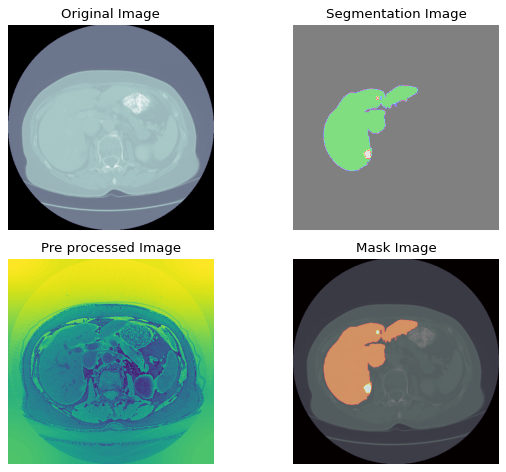

In [ ]:
sample = 57

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

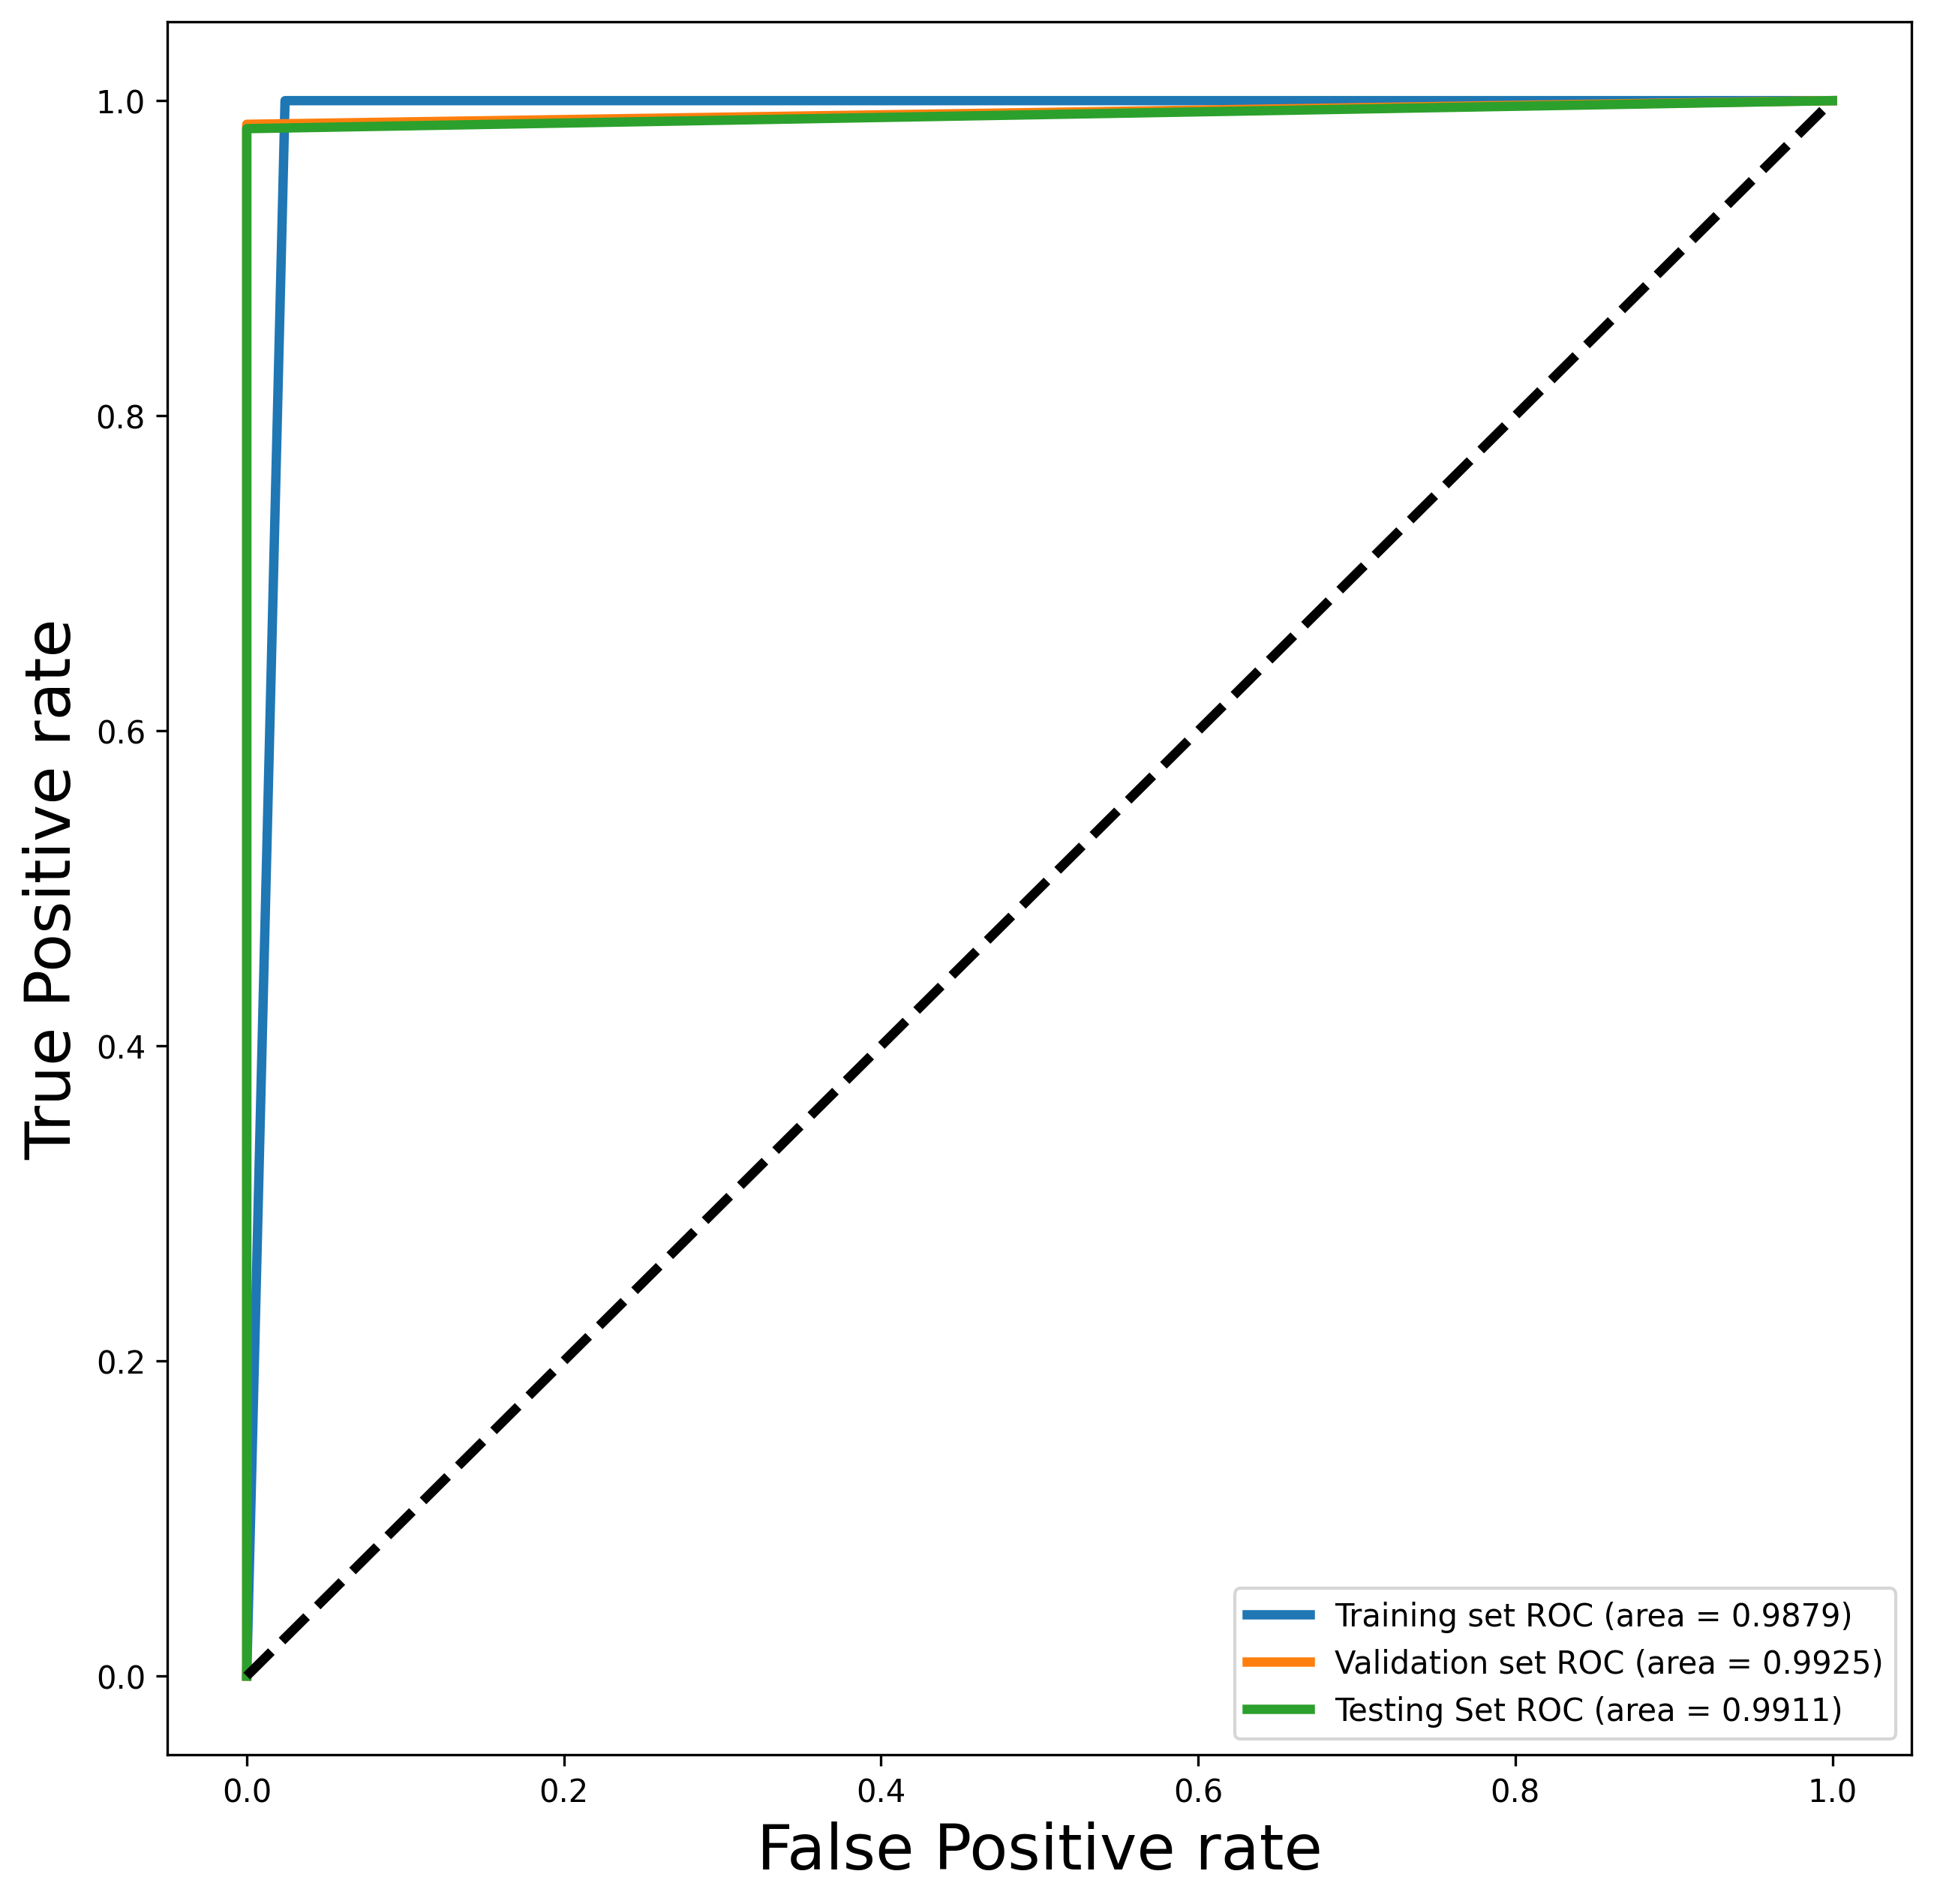

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
class_to_label_map = ['Training set ROC',"Validation set ROC","Testing Set ROC"]

def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(17, 6)):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure(figsize=(10, 10),dpi = 300)
    lw = 3

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=lw,
                 label='{0} (area = {1:0.4f})'
                 ''.format(class_to_label_map[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlabel('False Positive rate', fontsize=20)
    plt.ylabel('True Positive rate', fontsize=20)
#     plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

n_classes = len(class_to_label_map)
T = ([i for i in range(n_classes)]*1050)+[random.randint(0, n_classes) for i in range(n_classes*25)]
P = ([i for i in range(n_classes)]*1050)+[random.randrange(0, n_classes,3) for i in range(n_classes*25)]
testY = np.array(T)
predY = np.array(P)
predY = pd.get_dummies(predY, drop_first=False).values
plot_multiclass_roc(testY, predY, n_classes, figsize=(10, 10))